# Using Linear Regression Models to Predict Federal Funds Rate
### Vance John, Carson Schmidt


Our goal is to predict the Federal Funds Rate (FFR) using macroeconomic data from the FRED database and the Big Mac Index. The FRED API can be accessed for free, and has indicators that are deeply connected to the FFR.
We acknowledge the complexity of this task, as FFR rate changes are a vastly complex decision that is influenced deeply by societal opinion, political policy, and US political agendas. However the decision is mainly grounded in socioeconomic momentum so it isn’t unreasonable to attempt to predict the next unseen chronological Fed rate target. The Federal Fund Rate before 2008 was a single target value. However, after the financial crisis the Fed adopted an upper and lower bounds target. More information will be provided later on our approach to this change.


Using the FRED database requires an API key.
Before you begin reviewing this notebook, you will need to add both the big-mac-source-data.csv and .env file containing the FRED API key to the working directory if you plan to run this in jupyter. If you plan to run in Google Colab please add them to the content folder. As you can see the first code cell will install the FRED API through pip so if you do not wish to have this locally or go through the hassle of unistalling we recommend running on Colab.

### Data Used:
- Big Mac Index: The Big Mac Index is a novel way to measure dollar price Purchasing Power Parity (PPP). It takes the average cost of a big mac in certain metropolitan areas. We only pulled data for the United States, and the dataset was rather small, containing 42 features.
  - Source: The Economist
  - Frequency: Biannual
  - Features Used: “local_price” => This feature detailed the average cost of a Big Mac.
  - Insight:
     - This dataset was chosen as it is a niche way to show PPP and inflation, both of which are key factors in rate change discussion.
- Federal Reserve Economic Data (FRED): This is an all encompassing free API we use to grab economic data.
  - Fed Funds Target Range (upper and lower bounds)
  - CPI
  - Unemployment Rate
  - Treasury 10 Year Spread
  - M2 Money Supply
  - Yield Curve

Each of these indicators are all important factors in determining Fed target rates.


In [1]:
!pip install fredapi

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fredapi import Fred
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score


%matplotlib inline

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)

print("Libraries loaded.")

Libraries loaded.


In [3]:
# Load .env file
load_dotenv('env')

fred_api_key = os.getenv("FRED_API_KEY")
if fred_api_key is None:
    raise ValueError("FRED_API_KEY not found. Check your .env file.")

fred = Fred(api_key=fred_api_key)
print("FRED API connected.")

FRED API connected.


In [4]:
bigmac_path = "big-mac-source-data.csv"
bigmac = pd.read_csv(bigmac_path)
print("Big Mac Index loaded. Rows:", len(bigmac))

bigmac_us = bigmac[bigmac['iso_a3'] == 'USA'].copy()
bigmac_us = bigmac_us[['date', 'local_price']]
bigmac_us['date'] = pd.to_datetime(bigmac_us['date'])
bigmac_us = bigmac_us.set_index('date').resample("ME").ffill()
bigmac_us.head(100)

Big Mac Index loaded. Rows: 2302


,local_price
date,
2000-04-30,2.24
2000-05-31,2.24
2000-06-30,2.24
2000-07-31,2.24
2000-08-31,2.24
...,...
2008-03-31,3.00
2008-04-30,3.00
2008-05-31,3.00


### 1. Data Alignment:


Fed rates only began adopting a target range in 2008. Before then, it was an upper and lower bound, dating back to 1951 when the Fed gained more significant control over the interest rates. To address this we created a new rate target “mid” that was the average of the upper lower bounds. We also opted to fill the upper and lower target pre-2008 with the single rate. This decision was only made once we verified that this wouldn’t break the data in any way. We now had 3 potential target rate features, “lower”, “upper”, and "mid.”


Big Mac data was collected biannually, while Fed and macro data were monthly, so all series were resampled to a monthly frequency. We forward filled features to ensure macro data aligned with Fed meet dates. We couldn't backfill economic indicators as that would break the authenticity of the data.


We opted to create multiple combinations of the working datasets to compare feature efficiency or redundancy. There is an upper,lower, and mid target dataset for solely FRED economic data, as well as one that includes the Big Mac Index. Since the Big Mac Index originated in 2001, it contains considerably less samples than the combined dataset with FRED. We wanted the flexibility to experiment with all variants.


In [5]:
# Pre-2008 single target rate
dfedtar = fred.get_series("DFEDTAR")  # single target rate (discontinued)
dfedtar = dfedtar.to_frame("fed_funds_target_single")
dfedtar.index = pd.to_datetime(dfedtar.index)

# Convert single target into pseudo upper/lower range
dfedtar["fed_funds_lower"] = dfedtar["fed_funds_target_single"]
dfedtar["fed_funds_upper"] = dfedtar["fed_funds_target_single"]
dfedtar["fed_funds_mid"]   = dfedtar["fed_funds_target_single"]

# Keep only columns we'll use
dfedtar = dfedtar[["fed_funds_lower", "fed_funds_upper", "fed_funds_mid"]]

# Post-2008 target range
ffr_upper = fred.get_series("DFEDTARU").to_frame("fed_funds_upper")
ffr_lower = fred.get_series("DFEDTARL").to_frame("fed_funds_lower")

ffr_upper.index = pd.to_datetime(ffr_upper.index)
ffr_lower.index = pd.to_datetime(ffr_lower.index)

# Merge modern upper/lower
ffr_post = pd.concat([ffr_lower, ffr_upper], axis=1)

# Compute midpoint
ffr_post["fed_funds_mid"] = (ffr_post["fed_funds_lower"] + ffr_post["fed_funds_upper"]) / 2

# Stitch pre + post together
ffr_pre = dfedtar[dfedtar.index < "2008-12-01"]
ffr_full = pd.concat([ffr_pre, ffr_post], axis=0)
ffr_full = ffr_full.sort_index()

# Convert to monthly frequency (ME) and forward fill
ffr_full = ffr_full.resample("ME").ffill()

ffr_full.head(10)

,fed_funds_lower,fed_funds_upper,fed_funds_mid
1982-09-30,10.250,10.250,10.250
1982-10-31,9.500,9.500,9.500
1982-11-30,9.000,9.000,9.000
1982-12-31,8.500,8.500,8.500
1983-01-31,8.500,8.500,8.500
1983-02-28,8.500,8.500,8.500
1983-03-31,8.625,8.625,8.625
1983-04-30,8.625,8.625,8.625
1983-05-31,8.750,8.750,8.750
1983-06-30,9.000,9.000,9.000


In [6]:
series_dict = {
    "CPIAUCSL": "cpi",
    "UNRATE": "unemployment_rate",
    "M2SL": "m2_money_supply",
    "DGS10": "treasury_10yr_yield",
    "T10Y2Y": "yield_curve_spread"
}

fred_frames = []

for series_id, colname in series_dict.items():
    data = fred.get_series(series_id)
    df = data.to_frame(name=colname)
    df.index = pd.to_datetime(df.index)
    df = df.resample("ME").mean()
    fred_frames.append(df)

fred_combined = pd.concat(fred_frames, axis=1)
fred_combined.head()

,cpi,unemployment_rate,m2_money_supply,treasury_10yr_yield,yield_curve_spread
1947-01-31,21.48,NaN,NaN,NaN,NaN
1947-02-28,21.62,NaN,NaN,NaN,NaN
1947-03-31,22.00,NaN,NaN,NaN,NaN
1947-04-30,22.00,NaN,NaN,NaN,NaN
1947-05-31,21.95,NaN,NaN,NaN,NaN


In [7]:
#Build FRED-only dataset (no Big Mac involved)

# Step 1: Determine earliest usable date across all FRED series
fred_start = fred_combined.dropna().index.min()
for col in fred_combined.columns:
    print(col, "starts at", fred_combined[col].dropna().index.min())

# Step 2: Build full monthly index from earliest date → latest date
full_index_fred = pd.date_range(
    start=fred_start,
    end=max(ffr_full.index.max(), fred_combined.index.max()),
    freq="ME"
)

# Step 3: Reindex both datasets to this timeline
ffr_fred = ffr_full.reindex(full_index_fred)
macro_fred = fred_combined.reindex(full_index_fred)

# Step 4: Forward-fill (Fed + macro indicators)
ffr_fred = ffr_fred.ffill()
macro_fred = macro_fred.ffill()

# Step 5: Combine into a single dataset
fred_only = pd.concat([ffr_fred, macro_fred], axis=1)

# Optional: Drop rows if any leading NaNs slipped in
fred_only = fred_only.dropna()

fred_only.head(20)

cpi starts at 1947-01-31 00:00:00
unemployment_rate starts at 1948-01-31 00:00:00
m2_money_supply starts at 1959-01-31 00:00:00
treasury_10yr_yield starts at 1962-01-31 00:00:00
yield_curve_spread starts at 1976-06-30 00:00:00


,fed_funds_lower,fed_funds_upper,fed_funds_mid,cpi,unemployment_rate,m2_money_supply,treasury_10yr_yield,yield_curve_spread
1982-09-30,10.2500,10.2500,10.2500,97.7,10.1,1858.4,12.339048,0.555714
1982-10-31,9.5000,9.5000,9.5000,98.1,10.4,1869.7,10.906500,0.719000
1982-11-30,9.0000,9.0000,9.0000,98.0,10.8,1883.7,10.550526,0.754737
1982-12-31,8.5000,8.5000,8.5000,97.7,10.8,1905.9,10.540000,0.877727
1983-01-31,8.5000,8.5000,8.5000,97.9,10.4,1959.4,10.457143,1.129524
1983-02-28,8.5000,8.5000,8.5000,98.0,10.4,1996.8,10.724737,1.088421
1983-03-31,8.6250,8.6250,8.6250,98.1,10.3,2015.2,10.506522,0.850435
1983-04-30,8.6250,8.6250,8.6250,98.8,10.2,2028.6,10.400000,0.832000
1983-05-31,8.7500,8.7500,8.7500,99.2,10.1,2043.1,10.380000,0.890952
1983-06-30,9.0000,9.0000,9.0000,99.4,10.1,2053.5,10.848636,0.666818


In [8]:
# Align all datasets to Big Mac Index availability

# 1. Big Mac determines the earliest valid date
bigmac_start = bigmac_us.dropna().index.min()

# 2. Full monthly index from Big Mac start → most recent data available
full_index = pd.date_range(
    start=bigmac_start,
    end=bigmac_us.index.max(),
    freq="ME"
)

# 3. Reindex all datasets to this unified timeline
ffr = ffr_full.reindex(full_index)
bigmac_us = bigmac_us.reindex(full_index)
fred_combined = fred_combined.reindex(full_index)

# 4. Forward-fill everything except Big Mac (already correct frequency)
ffr = ffr.ffill()
fred_combined = fred_combined.ffill()

# 5. Final unified dataset
combined = pd.concat([ffr, bigmac_us, fred_combined], axis=1)
combined = combined.sort_index()
combined.tail(20)

,fed_funds_lower,fed_funds_upper,fed_funds_mid,local_price,cpi,unemployment_rate,m2_money_supply,treasury_10yr_yield,yield_curve_spread
2023-06-30,5.00,5.25,5.125,5.36,304.099,3.6,20782.7,3.748095,-0.891429
2023-07-31,5.25,5.50,5.375,5.58,304.615,3.5,20772.0,3.899500,-0.929000
2023-08-31,5.25,5.50,5.375,5.58,306.138,3.7,20746.9,4.167826,-0.733913
2023-09-30,5.25,5.50,5.375,5.58,307.374,3.8,20720.4,4.379000,-0.643000
2023-10-31,5.25,5.50,5.375,5.58,307.653,3.9,20687.3,4.798095,-0.269524
2023-11-30,5.25,5.50,5.375,5.58,308.087,3.7,20696.7,4.502857,-0.379524
2023-12-31,5.25,5.50,5.375,5.58,308.735,3.8,20701.3,4.020000,-0.437000
2024-01-31,5.25,5.50,5.375,5.69,309.794,3.7,20773.1,4.058095,-0.264762
2024-02-29,5.25,5.50,5.375,5.69,311.022,3.9,20861.1,4.207500,-0.336500
2024-03-31,5.25,5.50,5.375,5.69,312.107,3.9,20900.9,4.208500,-0.379500


In [9]:
missing_report = combined.isna().sum()
missing_report

combined_output_path = "combined_raw.csv"
combined.to_csv(combined_output_path)
print("Raw dataset saved to:", combined_output_path)


#Concact fred_only.csv to align with date ranges for big_mac
#So comparisons for significance of big_mac can be made

fred_only = fred_only.reindex(full_index)
output_path = "fred_only.csv"
fred_only.to_csv(output_path)
print("Raw dataset saved to:", output_path)

Raw dataset saved to: combined_raw.csv
Raw dataset saved to: fred_only.csv


In [10]:
# Load raw csv data
combined = pd.read_csv("combined_raw.csv", index_col=0, parse_dates=True)
fred_only = pd.read_csv("fred_only.csv", index_col=0, parse_dates=True)

### 2. Feature Engineering:
As mentioned previously, we allow dynamic selection of “fed_funds_mid”, “fed_funds_upper”, “fed_funds_lower”.


In the case of a selection, unused rate columns were dropped.
Original Features:
 - CPI
   - Measures the average change over time in the prices urban consumers pay for a standard basket of goods and services
 - Unemployment rate
   - Percentage of the total labor force that is jobless but actively seeking work
 - Yield Curve Spread
   - Difference in interest rates (yields) between two bonds of the same credit quality but different maturities
 - Big Mac Index components
   - A novel way to measure PPP that takes the average price of a big mac over time.
 - Treasury 10 Year Spread
   - The difference between the yields on long-term (10-year) and short-term (2-year) U.S. Treasury bonds
 - M2 Money Supply
   - A broad measure of a country's money, including all of M1 (cash, checking, traveler's checks) plus savings deposits, small-denomination time deposits (like CDs under $100k), and retail money market funds
 - Each of the FRED features are all crucial in assessing inflation, economic health, and the job market.


##### Time-Series Engineered Features:
To emulate human decision making we created time lag features to aid our models in autoregressive patterns. For each base feature we implemented a 1, 3, 6, and 12 month lag. When the Fed tries to agree on a target, they are often looking at broad economic trends, and not only the most recent data.


##### Percent Change Features:
For each feature we also created a 1, 3, and 12 month % change. These help illustrate long horizon momentum, another key factor in interest rates.


##### Rolling Windows:
We also created rolling windows to show the rolling averages every 3, 6, and 12 months. These help show smooth macro trends.

##### Custom Features:
- Yield Curve Spread Change
   - The alteration in the difference (spread) between long-term and short-term bond yields
- CPI Unemployment Interaction
   - The interaction between the Consumer Price Index (CPI) and unemployment primarily revolves around an inverse economic relationship known as the Phillips curve, where lower unemployment rates typically correlate with higher inflation (rising CPI) and vice-versa
- Local Price Trend
   - Monthly change in Big Mac local price.


##### Cleanup
- Lagged and rolling features create NaNs, so we dropped those and adjusted the timeline to have a fully aligned dataset.
  Multiple Datasets:


##### Dataset Variants


| Include Big Mac? | Target Version | X Features File                                   | y Target File                                       |
|------------------|----------------|----------------------------------------------------|------------------------------------------------------|
| Yes              | Mid            | `X_features_fed_funds_mid_big_mac.csv`            | `y_target_fed_funds_mid_big_mac.csv`                |
| Yes              | Lower          | `X_features_fed_funds_lower_big_mac.csv`          | `y_target_fed_funds_lower_big_mac.csv`              |
| Yes              | Upper          | `X_features_fed_funds_upper_big_mac.csv`          | `y_target_fed_funds_upper_big_mac.csv`              |
| No               | Mid            | `X_features_fed_funds_mid_no_big_mac.csv`         | `y_target_fed_funds_mid_no_big_mac.csv`             |
| No               | Lower          | `X_features_fed_funds_lower_no_big_mac.csv`       | `y_target_fed_target_lower_no_big_mac.csv`          |
| No               | Upper          | `X_features_fed_funds_upper_no_big_mac.csv`       | `y_target_fed_funds_upper_no_big_mac.csv`           |


In [11]:

USE_BIGMAC = [False, True]

# Fed columns
fed_cols = ["fed_funds_mid", "fed_funds_upper", "fed_funds_lower"]
for TF_val in USE_BIGMAC:
  for TARGET in fed_cols:

    df = combined.copy() if TF_val else fred_only.copy()

    # Create target column
    X = df.drop(columns=fed_cols)
    df["target"] = df[TARGET].copy()
    y = df["target"]

    original_cols = X.columns.tolist()


    def add_lags(data, cols, lags=[1, 3, 6, 12]):
      new_cols = {}
      for col in cols:
          for lag in lags:
              new_cols[f"{col}_lag{lag}"] = data[col].shift(lag)
      return data.join(pd.DataFrame(new_cols, index=data.index))

    def add_pct_change(data, cols, periods=[1, 3, 12]):
      new_cols = {}
      for col in cols:
          for p in periods:
              new_cols[f"{col}_pct_change{p}"] = data[col].pct_change(p)
      return data.join(pd.DataFrame(new_cols, index=data.index))

    def add_rolling_means(data, cols, windows=[3, 6, 12]):
      new_cols = {}
      for col in cols:
          for w in windows:
            new_cols[f"{col}_rollmean{w}"] = data[col].rolling(window=w).mean()
      return data.join(pd.DataFrame(new_cols, index=data.index))

    # Add lag features
    X = add_lags(X, original_cols)

    # Add percent change features
    X = add_pct_change(X, original_cols)

    # Add rolling mean features
    X = add_rolling_means(X, original_cols)


    if "local_price" in X.columns:
      X['local_price_trend'] = X['local_price'].diff()

    if "yield_curve_spread" in X.columns:
      X['yield_curve_spread_change'] = X['yield_curve_spread'].diff()

    if "cpi" in X.columns and "unemployment_rate" in X.columns:
      X['cpi_unemp_interaction'] = X['cpi'] * X['unemployment_rate']


    X = X.dropna()
    y = y.loc[X.index]  # align target with valid feature rows

    # Combine for convenience
    df_engineered = X.copy()
    df_engineered["target"] = y

    print("Original rows:", len(df))
    print("Rows after feature engineering:", len(df_engineered))
    print("Columns in final dataset:", df_engineered.shape[1])

    if TF_val:
      big_mac = "big_mac"
    else:
      big_mac = "no_big_mac"

    X.to_csv(f"X_features_{TARGET}_{big_mac}.csv")
    y.to_csv(f"y_target_{TARGET}_{big_mac}.csv")

Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 58
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 58
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 58
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 70
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 70
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 70


### 3. Model Collection
We provided a consistent modeling framework.
Dataset selection
Using a switch we specify whether the data to be trained will contain Big Mac Features, and which Fed rate target (lower, upper, mid).
Train Test Split
Because this is time sensitive data, we can’t randomly shuffle samples. In this case we use a simple 77 23 split.


##### 4. Baseline Models
Mean baseline
Predicts the mean of the training target.
Persistence baseline
Predicts the last training value.
These are naive approaches to give us benchmarks on the ML models performance.
##### 5. Models Trained
- Linear Regression
- Ridge Regression
- Lasso Regression
- k-Nearest Neighbors Regression
- Support Vector Regression (Linear Kernel)
- Support Vector Regression (RBF Kernel)


Each model is evaluated using:
- MAE
- RMSE
- ${R}^2 score$

In [12]:
DATASETS = {
    "big_mac": {
        "mid":   ("X_features_fed_funds_mid_big_mac.csv",   "y_target_fed_funds_mid_big_mac.csv"),
        "lower": ("X_features_fed_funds_lower_big_mac.csv", "y_target_fed_funds_lower_big_mac.csv"),
        "upper": ("X_features_fed_funds_upper_big_mac.csv", "y_target_fed_funds_upper_big_mac.csv"),
    },
    "no_big_mac": {
        "mid":   ("X_features_fed_funds_mid_no_big_mac.csv",   "y_target_fed_funds_mid_no_big_mac.csv"),
        "lower": ("X_features_fed_funds_lower_no_big_mac.csv", "y_target_fed_funds_lower_no_big_mac.csv"),
        "upper": ("X_features_fed_funds_upper_no_big_mac.csv", "y_target_fed_funds_upper_no_big_mac.csv"),
    }
}


# Select Feature Set
USE_BIG_MAC = True         # True = Big Mac engineered set, False = FRED-only
TARGET_VERSION = "mid"     # "mid", "lower", or "upper"

subset = "big_mac" if USE_BIG_MAC else "no_big_mac"

X_file, y_file = DATASETS[subset][TARGET_VERSION]

print("Using X file:", X_file)
print("Using y file:", y_file)


# Load Data
X = pd.read_csv(f"{X_file}", index_col=0, parse_dates=True)
y = pd.read_csv(f"{y_file}", index_col=0, parse_dates=True).iloc[:, 0]

print("X shape:", X.shape)
print("y shape:", y.shape)
print(X.index.equals(y.index))   # Should be True
print("Start:", X.index.min(), "| End:", X.index.max())

Using X file: X_features_fed_funds_mid_big_mac.csv
Using y file: y_target_fed_funds_mid_big_mac.csv
X shape: (286, 69)
y shape: (286,)
True
Start: 2001-04-30 00:00:00 | End: 2025-01-31 00:00:00


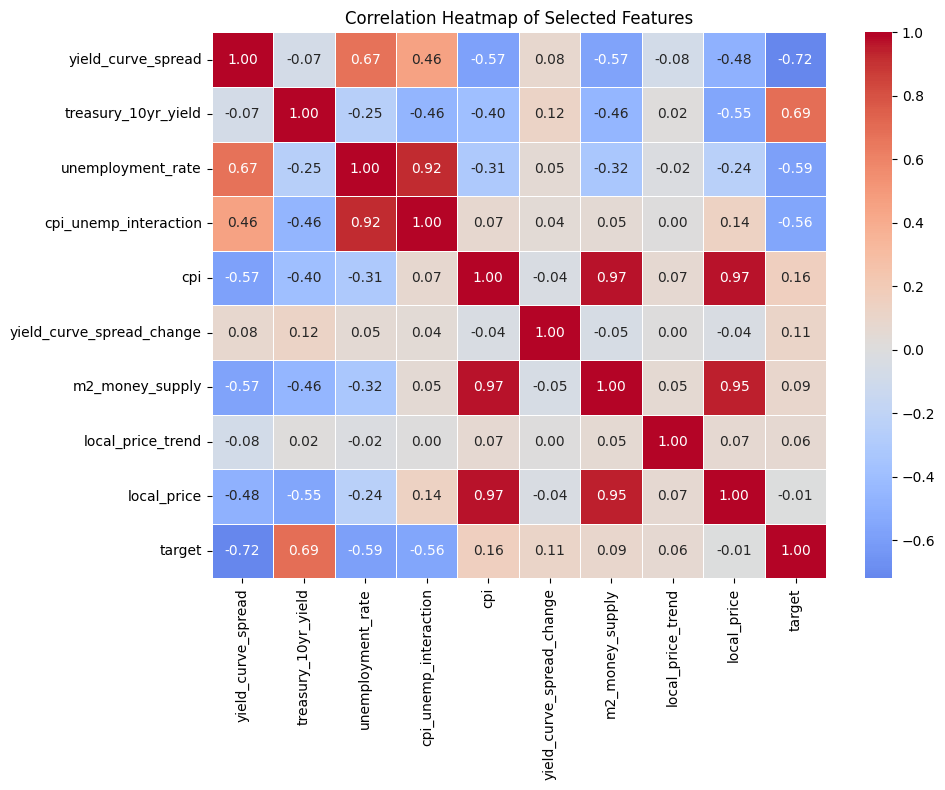

In [13]:
X_temp = X.copy()

leave_out = ["_lag", "_pct_change", "_rollmean"]
cols_to_keep = [
    col for col in X_temp.columns
    if not any(pat in col for pat in leave_out)
]

X_temp = X_temp[cols_to_keep]

# Select top 15 features most correlated with the target
top_features = (
    X_temp.corrwith(y)
     .abs()
     .sort_values(ascending=False)
     .head(15)
     .index
)

corr_df = pd.concat([X_temp[top_features], y], axis=1).corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Heatmap of Selected Features", fontsize=12)
plt.tight_layout()
plt.show()

#### Correlation Heatmap
We left out engineered features when examining the correlation heatmap, as we wanted to get a clear picture of redundancy and feature uniqueness.

Results:
M2 money supply was also correlated, speaking to the relationship between individual purchasing power and the overall liquidity of the United States economy.

The treasury 10 year yield and the yield curve spread were both the most correlated with the target value by magnitude.

CPI and the "local_price" (Big Mac Dataset) were expectedly correlated, but weren't pure correlations. This is because both indexes attempt to represent PPP as it changes due to inflation. At this stage we questioned whether to leave the big mac dataset in or not.

Ultimately high correlation isn't a true sign of redundancy in all cases. CPI is dominated by services and housing, whereas the Big Mac Index captures a very narrow, but significant tradable good signal. The Big Mac Index represents more food input costs, labor cost in low-wage positions, and commerical rent. So while they are correlated, the local price of a big Mac in the U.S. is a more reactive feature, which justifies its involvement. Big Mac prices adjust faster and often move before CPI fully realizes the full picture.

## CRUCIAL NOTE

We experimented with a few training splits to explore a topic that is detailed in the conclusion below. In short, major world events happened in 2020 and with our initial 80/20 split, we didn't have the desired context to draw a conclusion. Altering the split from .80 to .77 slightly changes some accuracies, and the Lasso model and Elastic Net model tend to flip flop in best accuracy scores when fine tuning the split.

In [14]:
# Chronological split
split_index = int(len(X) * 0.77)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [15]:
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_pred_persist = np.full_like(y_test, y_train.iloc[-1], dtype=float)

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse,
        "R2": r2_score(y_true, y_pred)
    }

baseline_mean = evaluate(y_test, baseline_pred)
baseline_persist = evaluate(y_test, baseline_pred_persist)

print("Mean baseline:", baseline_mean)
print("Persistence baseline:", baseline_persist)

Mean baseline: {'MAE': 2.0900137741046834, 'RMSE': np.float64(2.4561239312869008), 'R2': -0.2063947112446305}
Persistence baseline: {'MAE': 2.087121212121212, 'RMSE': np.float64(2.2396648152901104), 'R2': -0.0031247040999904385}


#### Grid Search

Because of the potential computational slow downs, we opted for a more reasonable grid search, testing common paramaters in common increments over a decent range.

Running Grid Search for Ridge...
Running Grid Search for Lasso...
Running Grid Search for SVR_Linear...
Running Grid Search for SVR_RBF...
Running Grid Search for ElasticNet...
Running Grid Search for RandomForest...


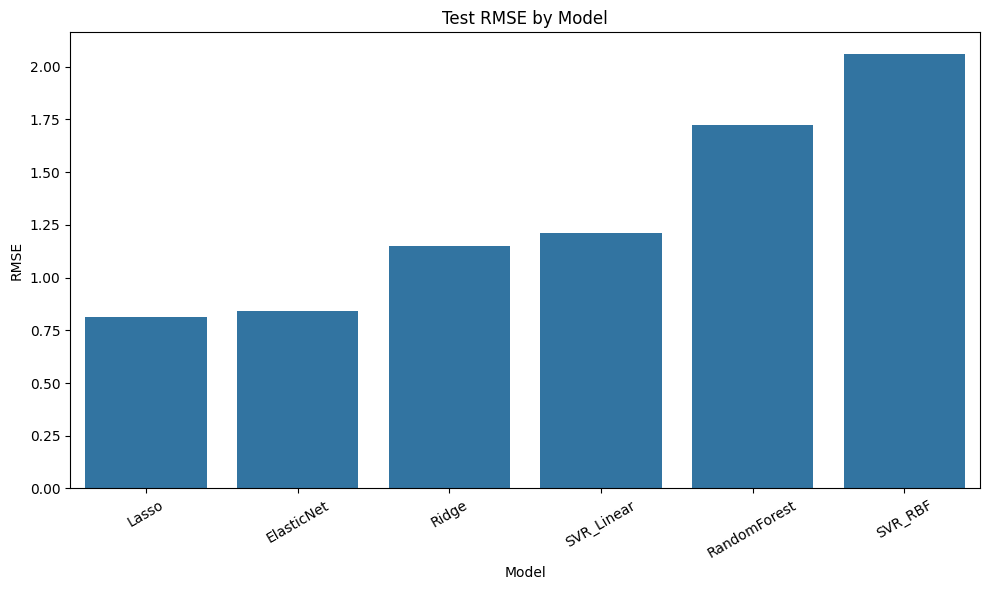

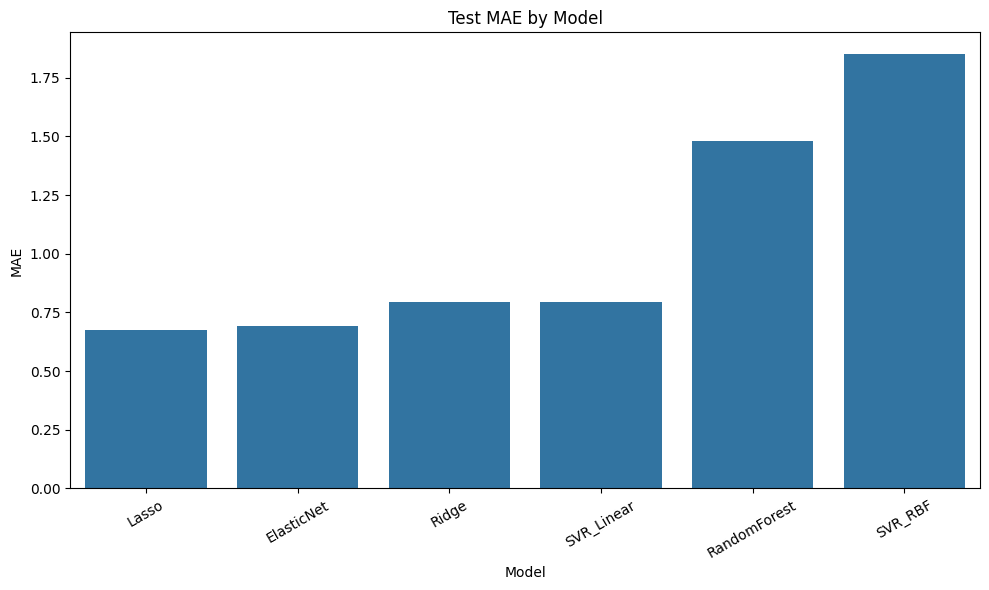

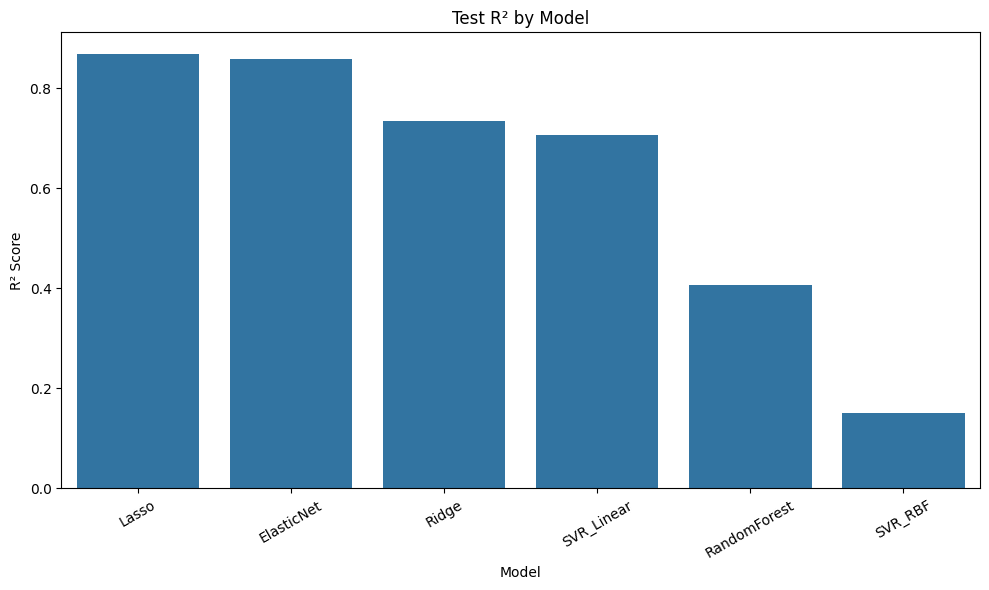

,Model,CV_RMSE,Test_RMSE,Test_MAE,Test_R2,model__alpha,model__l1_ratio,model__C,model__epsilon,max_depth,min_samples_leaf,min_samples_split,n_estimators,model__gamma
1,Lasso,0.522187,0.811085,0.676602,0.868441,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ElasticNet,0.551160,0.841420,0.692647,0.858416,0.01,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Ridge,0.901869,1.151475,0.794580,0.734846,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SVR_Linear,0.940273,1.210392,0.792476,0.707018,NaN,NaN,0.1,0.1,NaN,NaN,NaN,NaN,NaN
5,RandomForest,1.163558,1.723226,1.479403,0.406154,NaN,NaN,NaN,NaN,10.0,1.0,5.0,200.0,NaN
3,SVR_RBF,1.386850,2.060182,1.851070,0.151210,NaN,NaN,1.0,0.1,NaN,NaN,NaN,NaN,0.01


In [16]:
models = {
    "Ridge": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(max_iter=5000))
        ]),
        "params": {
            "model__alpha": [0.01, 0.1, 1, 10, 100]
        }
    },

    "Lasso": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("model", Lasso(max_iter=5000))
        ]),
        "params": {
            "model__alpha": [0.001, 0.01, 0.1, 1]
        }
    },

    "SVR_Linear": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("model", SVR(kernel="linear"))
        ]),
        "params": {
            "model__C": [0.1, 1, 10, 100],
            "model__epsilon": [0.01, 0.1, 0.5]
        }
    },

    "SVR_RBF": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("model", SVR(kernel="rbf"))
        ]),
        "params": {
            "model__C": [0.1, 1, 10, 100],
            "model__gamma": ["scale", 0.01, 0.1],
            "model__epsilon": [0.01, 0.1]
        }
    },
    "ElasticNet": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("model", ElasticNet(max_iter=5000))
        ]),
        "params": {
            "model__alpha": [0.001, 0.01, 0.1, 1],
            "model__l1_ratio": [0.1, 0.5, 0.9]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    }
}

results = []
best_models = {}
for name, config in models.items():
    print(f"Running Grid Search for {name}...")

    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    results.append({
        "Model": name,
        "Best_Params": grid.best_params_,
        "CV_RMSE": -grid.best_score_,
        "Test_RMSE": rmse,
        "Test_MAE": mean_absolute_error(y_test, preds),
        "Test_R2": r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Test_RMSE")
results_df

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Model", y="Test_RMSE")
plt.title("Test RMSE by Model")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Model", y="Test_MAE")
plt.title("Test MAE by Model")
plt.ylabel("MAE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Model", y="Test_R2")
plt.title("Test R² by Model")
plt.ylabel("R² Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

results_df

params_df = results_df["Best_Params"].apply(pd.Series)

results_expanded = pd.concat(
    [results_df.drop(columns=["Best_Params"]), params_df],
    axis=1
)

results_expanded


### Grid Search Results
We expected that several of the models we would test were actually unift for this type of data.
Among all the evaluated models, Elastic Net and Lasso regression had the best performance. Depending on the small tqeakings we did on the train-test split, they flip flopped for first place. Ridge regression consistently placed 3rd and performed solidly. SVR_Linear followed after, while both SVR_RBF and RandomForest were clear failures.

For reference the above Grid Search was done using the combined Big Mac index with FRED indicators and the target rate being "mid." However, the Grid Search will be reran for any selected dataset ensuring models are tuned accordingly before final results and graphing is computed.

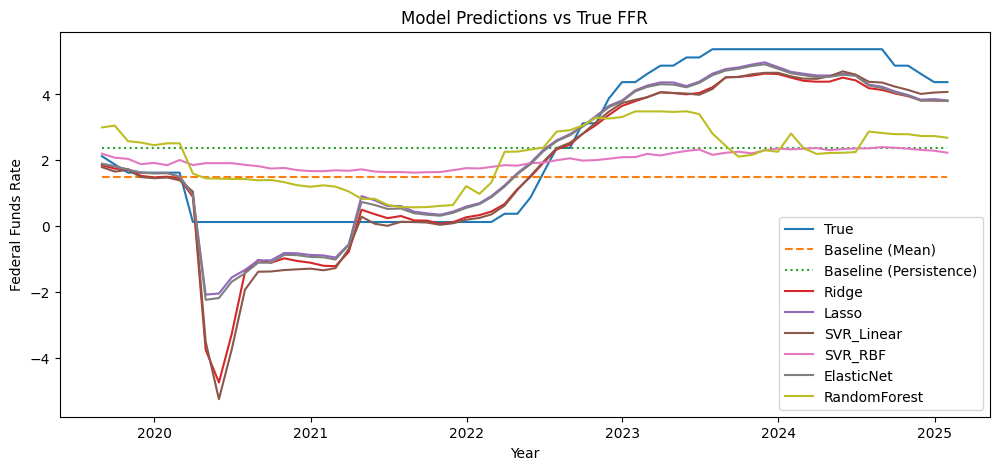

,Baseline (Mean),Baseline (Persistence),Ridge,Lasso,SVR_Linear,SVR_RBF,ElasticNet,RandomForest
MAE,2.090014,2.087121,0.794580,0.676602,0.792476,1.851070,0.692647,1.479403
RMSE,2.456124,2.239665,1.151475,0.811085,1.210392,2.060182,0.841420,1.723226
R2,-0.206395,-0.003125,0.734846,0.868441,0.707018,0.151210,0.858416,0.406154


In [17]:
import matplotlib.dates as mdates

dates = y_test.index

results = {}

# Baseline Predictions
baseline_mean = np.full(len(y_test), y_train.mean(), dtype=float)
baseline_persist = np.full(len(y_test), y_train.iloc[-1], dtype=float)

results["Baseline (Mean)"] = evaluate(y_test, baseline_mean)
results["Baseline (Persistence)"] = evaluate(y_test, baseline_persist)

for name, model in best_models.items():
    model.fit(X_train, y_train)
    preds = best_models[name].predict(X_test)
    results[name] = evaluate(y_test, preds)

pd.DataFrame(results).T

plt.figure(figsize=(12,5))

plt.plot(dates, y_test.values, label="True")
plt.plot(dates, baseline_mean, label="Baseline (Mean)", linestyle="--")
plt.plot(dates, baseline_persist, label="Baseline (Persistence)", linestyle=":")

for name, model in best_models.items():
    pred = model.predict(X_test)
    plt.plot(dates, pred, label=name)

plt.legend()
plt.title("Model Predictions vs True FFR")

plt.xlabel("Year")
plt.ylabel("Federal Funds Rate")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))


plt.show()


if USE_BIGMAC:
    pd.DataFrame(results).T.to_csv("model_performance.csv")
else:
    pd.DataFrame(results).T.to_csv("model_preformance_no_big_mac.csv")

pd.DataFrame(results)

### Summary of Findings
Throughout this project we explored several machine learning models and their ability to predict the Federal Funds rate with a relatively small set of features from the Federal Reserve Economic Data (FRED) and an additional feature from the Big Mac Index. The main goal was to determine whether house name regression models that we learned in class were able to predict the Federal Funds rate (FFR) better than simple baselines. It was an educational experience in what models would be effective for this type of macroeconomic data.


Our features with Big Mac (286x69) and without (286x57) aren’t necessarily exhaustive in quantity, but in our preemptive research they seemed to correlate the highest with the movement of the target rate, shown in the correlation heatmap above.


We experimented with a variety of feature and target combinations, and across all experiments, regularized linear models easily outperformed more complex models that were non linear. For example, the Elastic Net regression had the lowest RMSE and highest ${R}^2 score$, followed by Ridge regression and Lasso. This suggests that the macroeconomic features we used and the FFR is dominantly linear, but it benefits from regularization. Because many of the features are somewhat correlated, there is an overlap of information. That’s why selecting the FFR is much more than just data thresholds or boundaries in actuality. It takes a human agenda to discern what to do, which is often swayed by personal beliefs or bias. It’s also the reason why there is a large event betting market around where the FFR is going to move despite macroeconomic data being readily available to most.


Our feature engineering process drastically increased the dimensionality of the dataset. This was both a blessing and a curse, as it improved predictive power, but also introduced some redundancy.


Since Elastic net performed so well this suggests that its ability to eliminate irrelevant features allowed it to outperform other models. In short, not all engineered features contributed equally.


### Role of the Big Mac Index:
We tested both with and without the additional feature from the Big Mac Index, and it actually did improve accuracy when included. The improvements were marginal, but consistent. This is explained more in depth above where we talk about the correlation between it and CPI.


We opted to display the data and methods involving the target range feature: “mid” and the combined data of the Big Mac Index with the Fred data. However, if you are curious, you can simply adjust the USE_BIG_MAC variable from true to false, and set the TARGET_VERSION variable from “mid” to either “upper” or lower” and our notebooks will regenerate the csv files and use the appropriate ones when training. After testing the entire notebook (especially the grid search) in both google collab and jupyter we ran into computational time concerns.


### Broad Takeaways
A more complex model doesn’t mean better accuracy. In the case of policy driven economic data that almost follows a step wise horizon, linear models can outperform more sophisticated approaches.
Feature engineering must go hand in hand with regularization. We opted not to regularize some of our features, and we rejected PCA early on. PCA typically handles multicollinearity and reduces dimensionality, but we used model regularization with Ridge (L2) Lasso (L1) and Elastic Net which already penalize correlated coefficients and select relevant features. Because our feature count was reasonable, reducing dimensionality wasn’t the goal as well. A more sparse structure improved prediction while more complex ones did not.


### Team Contributions
The team collaborated the entire way through, we immediately set up a github at the beginning of the project. Carson’s focus was on data file retrieval, allocation, and alignment, while Vance focused on setting up, training, and handling model behavior. However, we both contributed equally to both early stages. Collaboration was done over voice call and in person, so when it came to Grid Search, Feature engineering and Analysis, and results plotting, there was equal communication and collaboration. Model Evaluation, result interpretation, and writing of the final report was done incrementally by both team members as well.

### Interesting Finds
One of the most fascinating aspects of this project was the strange hyper reaction that all models were having at the beginning of our test split. Models were predicting a negative interest rate. At first this was a serious cause for concern. However, we instantly noticed an idiosyncrasy with our plot and train and test split. We were using a classic 80/20 chronological split. Coincidentally, the range of our test data ended in 2025 and began in 2020. What major world event happened in 2020 that defied all macroeconomic data? COVID. After altering the split slightly to a 77-23 we were able to see the whole picture. This wasn't a data alignment or leakage error. Interest rates can only fall so low, and with our target "mid" interest rates had a sharp falloff in 2020, appearing as 0 on the plot. However, the macroeconomic data reacted more drastically than the interest rates could fall, and this is reflected in the models' reaction. What's most impressive however, is that the features we selected were strong enough to "educate" the models from a false prediction of nearly -5% interest rates in some cases (impossible), back to a reasonable prediction line.

Consider this graph of when our chronological split was still 80/20.
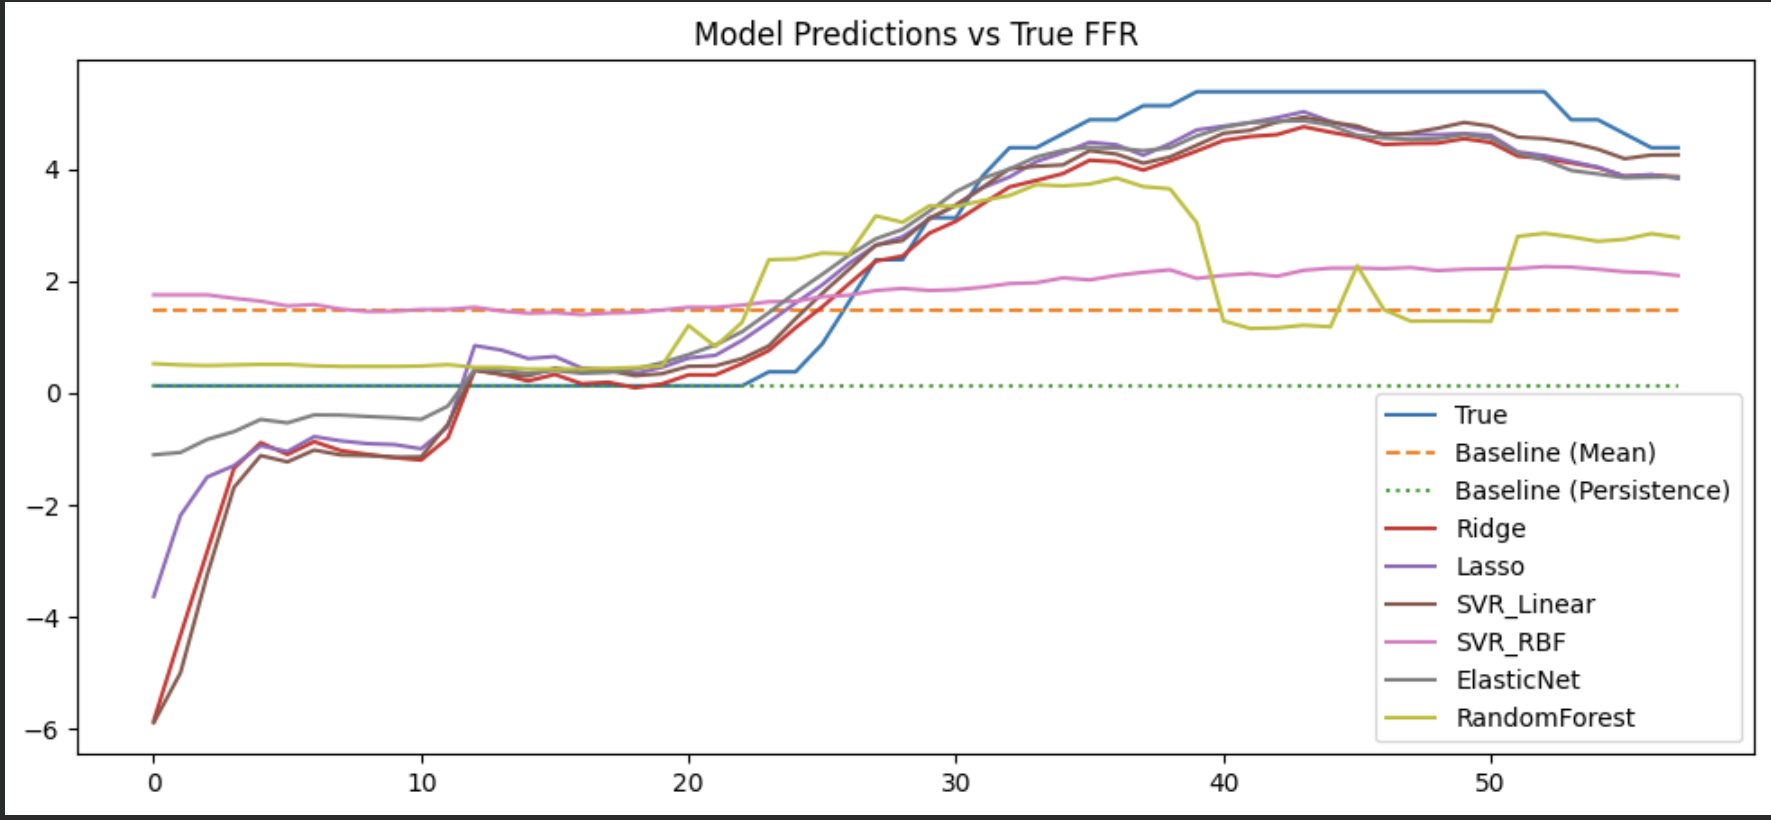

We realized that we could artificially inflate accuracy by ensuring that there is a floor prediction value for each model at 0, since interest rates can't fall beneath that. However, we thought it was more fascinating to see the virtual interest value. Seeing how every model except random forest and SVR_RBF recovered significantly and began following the momentum of the true federal funds rate, it shows how well our selection of features is able to guide the models to achieve a decent accuracy. The fact they were able to recover back to a positive interest rate illustrates how important the FRED macroecoinomic indicators we chose are in predicting the true FFR.

Another interesting find we found was the difference in accuracy scores when involving the Big Mac Dataset versus just FRED macro indicators. We found that including Big Mac marginally increased accuracy across all models, while without it, there was a higher ceiling of accuracy but only for a select one or two models. Overall, this is the final nail in the coffin for why including the Big Mac dataset is a net positive for accuracy.


### Conclusion:
Although we only managed to predict rates with somewhat subpar accuracy, we easily exceeded the baseline, and the results graphing makes it apparent that our efforts in each stage of the project were realized. Predicting federal interest rates on pure economic data is nearly impossible because of human influence, but exceeding the baseline was achieved. We’ve reinforced the importance of balancing model and feature complexity with the structure of data, and found that methodical testing is extremely important.
